## Lab - EDA Bivariate Analysis: Diving into Amazon UK Product Insights Part II

### Part 0: Load the dataset
Load the information to a dataframe, import the necessary libraries and other necessary configurations to get started.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from kaggle.api.kaggle_api_extended import KaggleApi

In [3]:
api = KaggleApi()
api.authenticate()

# Download the dataset using the Kaggle API
api.dataset_download_files('asaniczka/uk-optimal-product-price-prediction', path='.', unzip=True)

# Read CSV file using pandas
import pandas as pd
df = pd.read_csv('amz_uk_price_prediction_dataset.csv')

# Show the first columns of the dataframe
df.head(5)

Dataset URL: https://www.kaggle.com/datasets/asaniczka/uk-optimal-product-price-prediction


,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2443651 entries, 0 to 2443650
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   uid                int64  
 1   asin               object 
 2   title              object 
 3   stars              float64
 4   reviews            int64  
 5   price              float64
 6   isBestSeller       bool   
 7   boughtInLastMonth  int64  
 8   category           object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 151.5+ MB


### Part 1: Analyzing Best-Seller Trends Across Product Categories

**Objective**: Understand the relationship between product categories and their best-seller status.

1. **Crosstab Analysis**:
    - Create a crosstab between the product `category` and the `isBestSeller` status.
    
    - Are there categories where being a best-seller is more prevalent? 
    	
    	*Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.*


In [5]:
# Create a cross-tabulation of the category and isBestSeller columns.
category_bestseller = pd.crosstab(df['category'], df['isBestSeller'])
category_bestseller

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [13]:
#Get the proportion table to understand the relative importance of each category.
percent_bestseller = (category_bestseller[True] / (category_bestseller[True] + category_bestseller[False])) * 100

# Convert to a dataframe to order the values
percent_bestseller_df = pd.DataFrame({'percentage_true': percent_bestseller})
top_10 = percent_bestseller_df.sort_values(by='percentage_true', ascending=False).head(10)
top_10

,percentage_true
category,
Grocery,5.813467
Smart Home Security & Lighting,5.769231
Health & Personal Care,5.768628
Mobile Phone Accessories,4.247104
Power & Hand Tools,3.533895
"Billiard, Snooker & Pool",3.212851
Pet Supplies,3.020028
Home Brewing & Wine Making,2.845528
Wind Instruments,2.800000


In [15]:
percent_bestseller_df.describe()

,percentage_true
count,296.000000
mean,0.616085
std,0.901211
min,0.000000
25%,0.061028
50%,0.319577
75%,0.779736
max,5.813467


Yes, there is significant variability in the percentages of “bestseller” products, as we see in the standard deviation of 0.91. The maximum of 5.81% is well above the average, we see that there are some categories that clearly stand out in the “bestseller” products. Like Grocery, Smart Home Security & Lighting, Health & Personal Care and Mobile Phone Accessories categories with more than 4% of bestsellers.

2. **Statistical Tests**:
    - Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
    - Compute Cramér's V to understand the strength of association between best-seller status and category.

In [8]:
# Import the library with the formula
import scipy.stats as stats

# Realize the chi-square test
chi2, p, dof, expected = stats.chi2_contingency(category_bestseller)

chi2, p

(36540.20270061387, 0.0)

The chi-square value is high, which means that there is an important difference and according to the p-value, the probability that these differences are due to chance is practically zero. The relationship between these two variables is significant.

In [9]:
#Compute Cramér's V to understand the strength of association between best-seller status and category.
n = category_bestseller.sum().sum()
cramers_v = np.sqrt((chi2 / n) / (min(category_bestseller.shape) - 1))
cramers_v

0.1222829439760564

However, applying Cramer's we have seen that the relationship is not strong, with only 0.12.

3. **Visualizations**:
	- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.


<Axes: xlabel='category'>

<Figure size 3000x600 with 0 Axes>

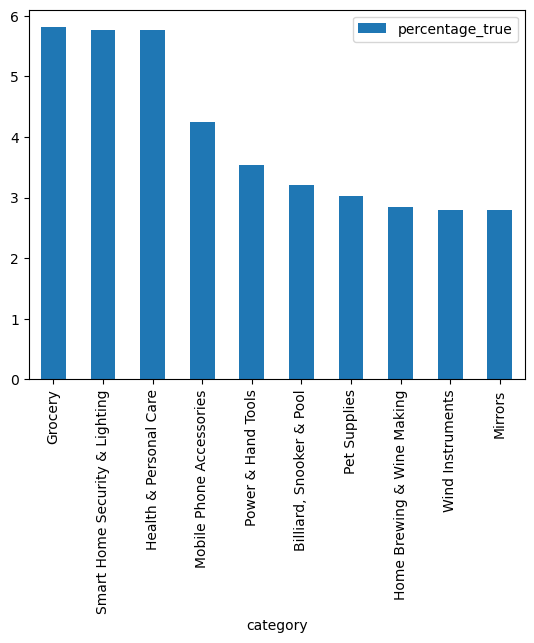

In [16]:
# Plotting a stacked bar chart for the 'crosstab_result' data
plt.figure(figsize=(30, 6))
top_10.plot(kind="bar", stacked=True)

### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

**Objective**: Investigate how different product categories influence product prices.

0. **Preliminary Step: Remove outliers in product prices.**

	For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.
	
	*Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.*

In [11]:
# Calculate the first and third quartiles
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)

# Calcular el IQR
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Apply the lower and upper bounds to the DataFrame for removal of outliers
df_cleaned = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

1. **Violin Plots**:
    - Use a violin plot to visualize the distribution of `price` across different product `categories`. Filter out the top 20 categories based on count for better visualization.
    - Which product category tends to have the highest median price? Don't filter here by top categories.


C:\Users\almuo\AppData\Local\Temp\ipykernel_19232\4123664497.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=top_20, x='category', y='price', palette="coolwarm")


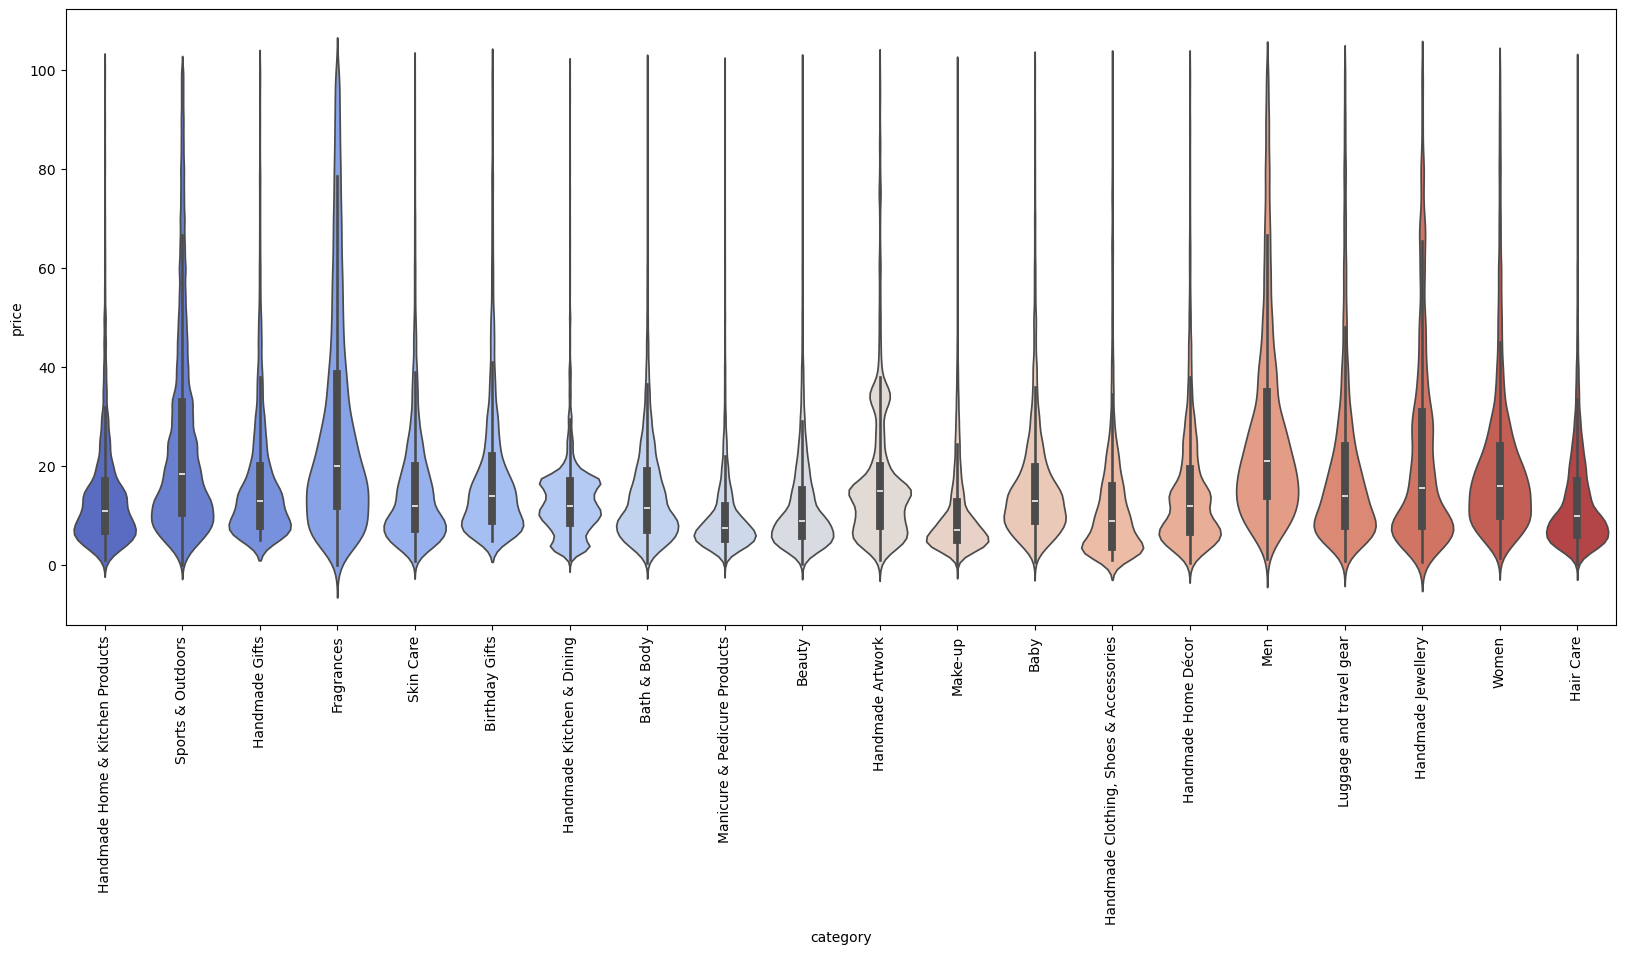

In [24]:
#Creating the top 20 categories based on count
top_20_categories = df_cleaned['category'].value_counts().nlargest(20).index
top_20 = df_cleaned[df_cleaned['category'].isin(top_20_categories)]

# Plotting a violin plot to visualize the distribution of 'price' for each 'category'
plt.figure(figsize=(20, 8))
sns.violinplot(data=top_20, x='category', y='price', palette="coolwarm")
plt.xticks(rotation=90)
plt.show()

2. **Bar Charts**:
    - Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
    - Which product category commands the highest average price? Don't filter here by top categories.

In [27]:
#Creating the top 10 categories based on count
top_10_categories = df_cleaned['category'].value_counts().nlargest(10).index
top_10 = df_cleaned[df_cleaned['category'].isin(top_10_categories)]

#Calculate the average price for each category  
avg_price = top_10.groupby('category')['price'].mean()

C:\Users\almuo\AppData\Local\Temp\ipykernel_19232\1020116106.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price.index, y=avg_price.values, palette="coolwarm")


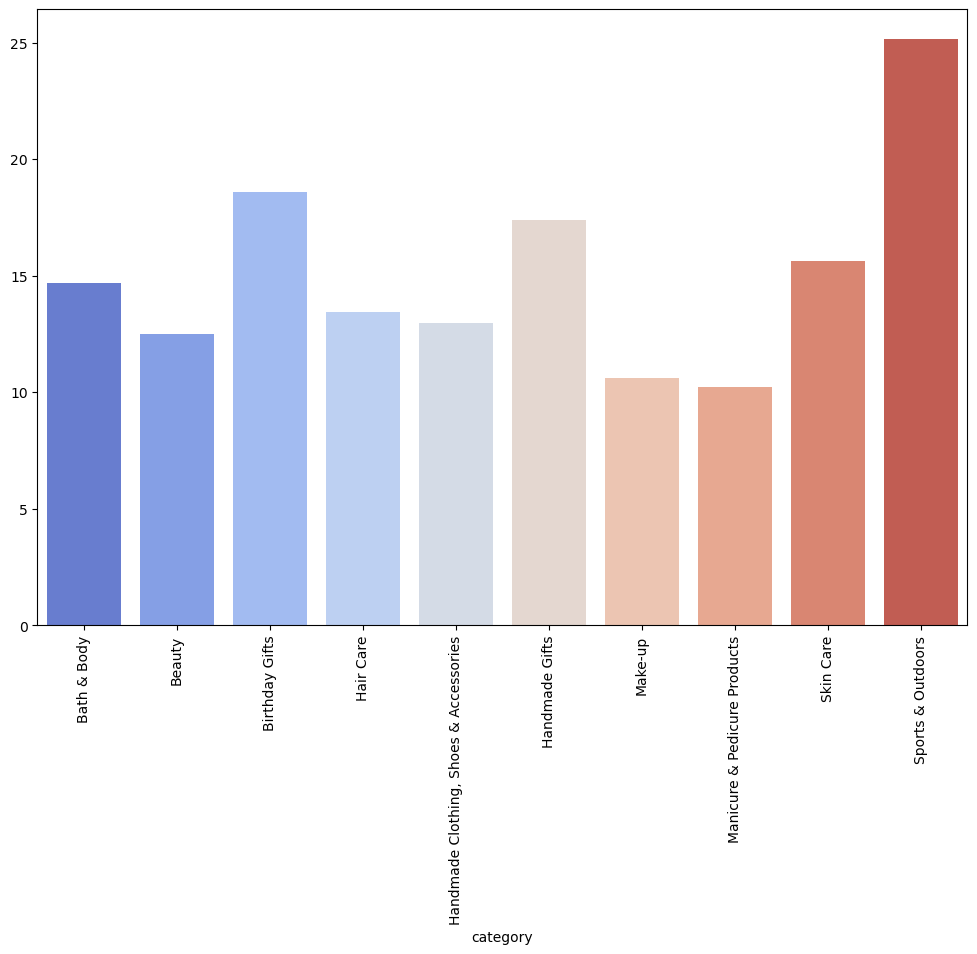

In [29]:
#Create a bar chart comparing the average price of products for the top 10 product categories
plt.figure(figsize=(12, 8))
sns.barplot(x=avg_price.index, y=avg_price.values, palette="coolwarm")
plt.xticks(rotation=90)
plt.show()

3. **Box Plots**:
    - Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.


In [35]:
#Clean the rating outliers
df_cleaned = df_cleaned[df_cleaned['stars'] > 0]

#Filter top 10 categories based on product counts
top_10_categories = df_cleaned['category'].value_counts().nlargest(10).index
top_10 = df_cleaned[df_cleaned['category'].isin(top_10_categories)]

C:\Users\almuo\AppData\Local\Temp\ipykernel_19232\2978221909.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=top_10, x='category', y='stars', palette="coolwarm")


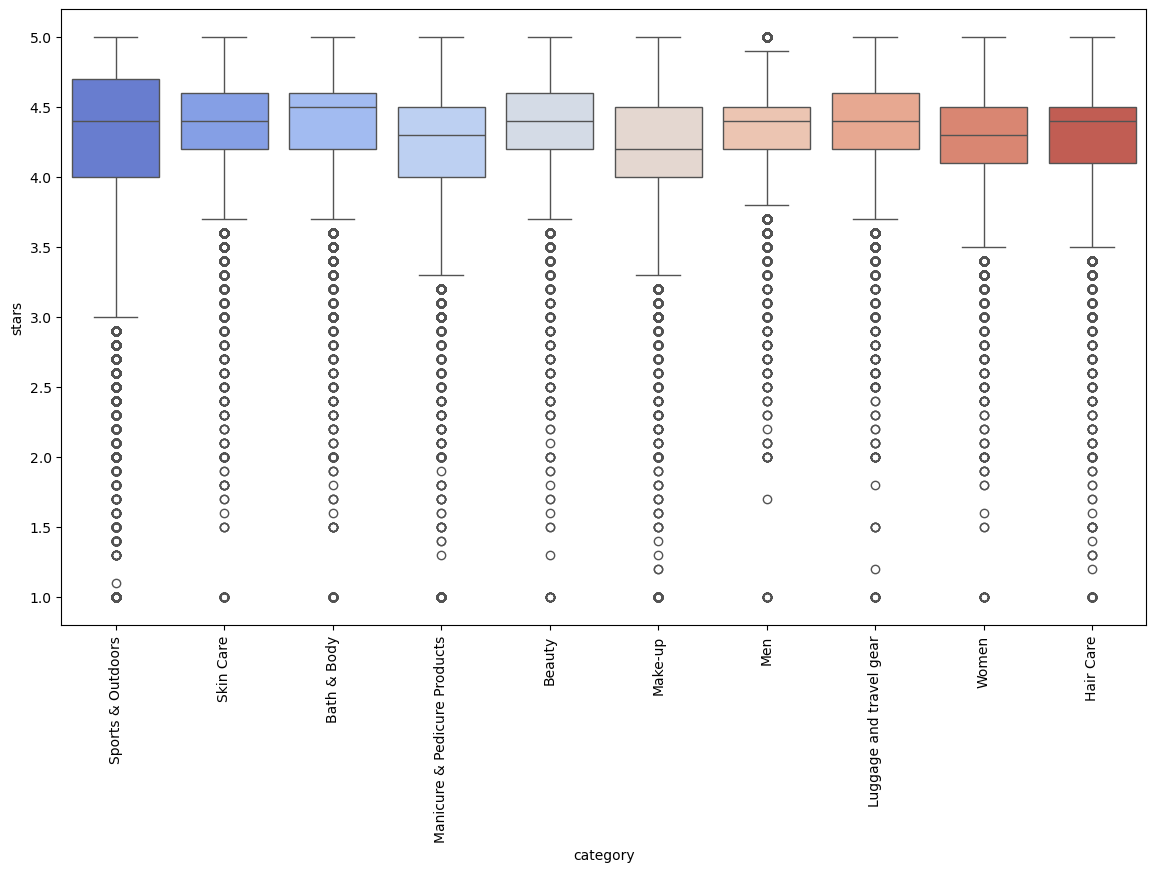

In [36]:
# Plotting a box plot to visualize the spread and outliers of ratings for each category
plt.figure(figsize=(14, 8))
sns.boxplot(data=top_10, x='category', y='stars', palette="coolwarm")
plt.xticks(rotation=90)
plt.show()

### Part 3: Investigating the Interplay Between Product Prices and Ratings

**Objective**: Analyze how product ratings (`stars`) correlate with product prices.

1. **Correlation Coefficients**:
    - Calculate the correlation coefficient between `price` and `stars`.
    - Is there a significant correlation between product price and its rating?

In [38]:
# Calculate the correlation between 'price' and 'stars'
correlation = df_cleaned[['price', 'stars']].corr()
correlation

,price,stars
price,1.000000,0.006745
stars,0.006745,1.000000


There's no linear relationship between price and rating, because the coefficient is very close to 0.

2. **Visualizations**:
    - Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
    - Use a correlation heatmap to visualize correlations between all numerical variables.
    - Examine if product prices typically follow a normal distribution using a QQ plot. 


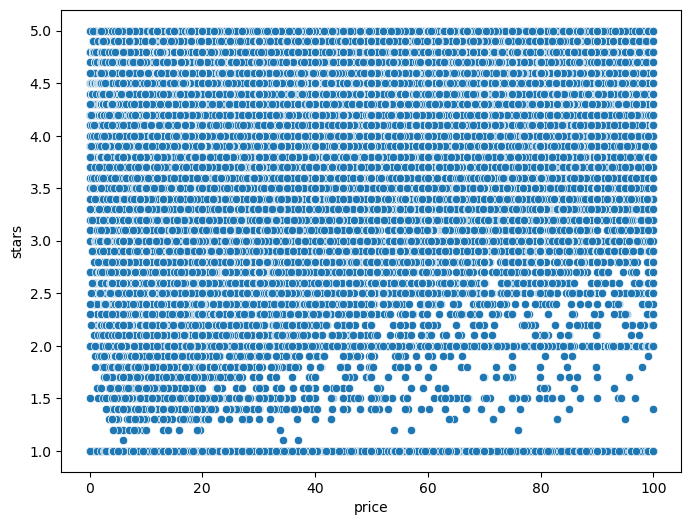

In [39]:
#create scatter plot for seeing the correlation between 'price' and 'stars'
plt.figure(figsize=(8, 6))
sns.scatterplot(x='price', y='stars', data=df_cleaned)
plt.show()

<Axes: >

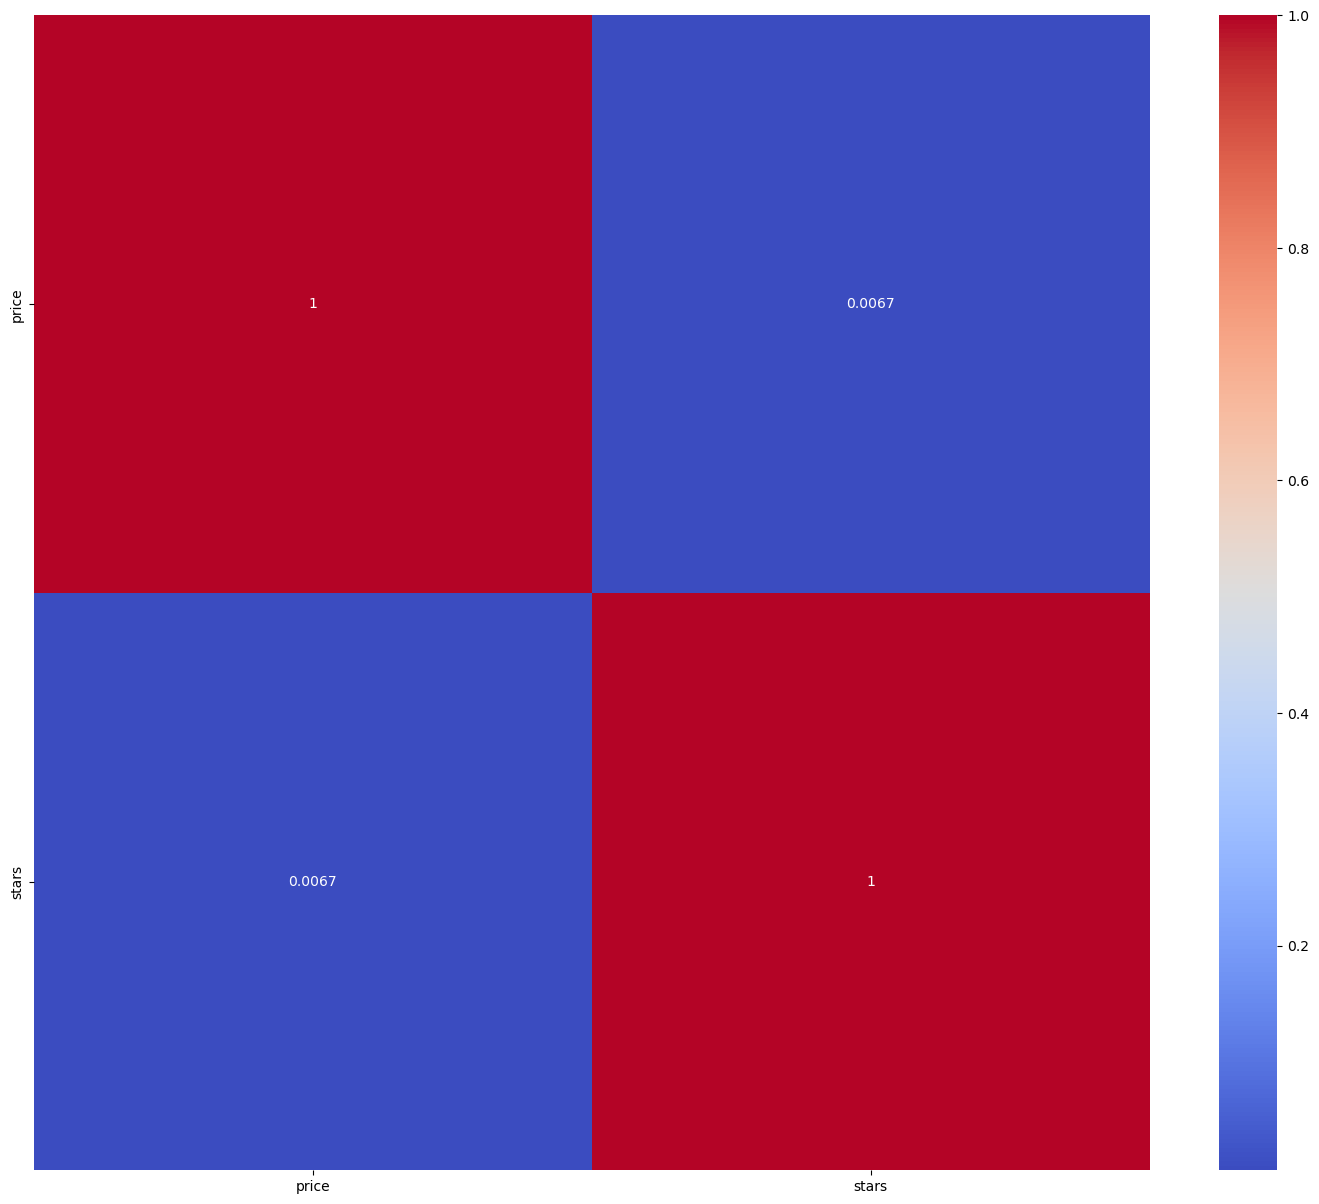

In [40]:
#Calculate the correlation between 'price' and 'stars'
correlation_matrix = df_cleaned[['price', 'stars']].corr()

# Setting up the matplotlib figure with an appropriate size
plt.figure(figsize=(18, 15))

# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")